# Enron, do Império à Migalhas: uma breve abordagem de Machine Learning

In [1]:
from IPython.display import Image
Image(url="http://famous-trials.com/legacyftrials/enron/enroncartoon.gif")

Neste artigo abordaremos uma grande tragédia americana, ou melhor, uma grande tragédia de uma empresa americana que hoje não mais existe. A Enron Corporation foi uma companhia de energia estadunidense, localizada em Houston, Texas. Empregava cerca de 21.000 pessoas, tendo sido uma das empresas líderes no mundo em distribuição de Energia, Gás Natural e Comunicações (Wikipédia). Em meados de 2000, a Enron era uma das maiores empresas nos Estados Unidos, em 2002 entrou em falência devido a uma fraude corporativa generalizada e um dos maiores escândalos de corrupção da história americana. Na investigação federal resultante, houve uma quantidade significativa de informações tipicamente confidenciais inseridas no registro público, incluindo dezenas de milhares de e-mails e dados financeiros detalhados dentre os principais executivos.

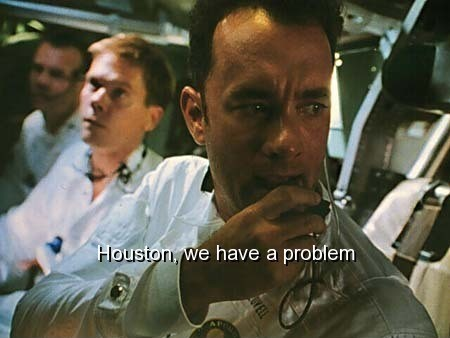

In [2]:
from IPython.display import Image
Image(filename="Houston.jpg")

Este artigo foi embasado no meu projeto (incluir link) do módulo de Machine Learning do curso Nanodegree de Análise de Dados da Udacity. O objetivo foi construir um identificador de _Person of Interest_ (POI) com base em dados financeiros e de e-mails tornados públicos de 146 executivos. Para a construção do identificador realizei uma limpeza dos dados e testei diversos algoritmos afim de obter as melhores pontuações nas principais métricas _accuracy_, _precision_ e _recall_.

É pertinente mencionar que o dataset deste projeto possui um problema sério conhecido como _Data leakage_, termo em inglês que significa "vazamento" e por definição isso ocorre quando é vazado qualquer informação do dataset de teste para o de treino, como já sabemos quem são os POIs acabamos enviesando totalmente o dataset de treino com as _features_, porém, como esse tópico não foi abordado no meu curso por ter sido um módulo introdutório de aprendizagem de máquina (data leakage é um assunto avançado e valeria um artigo inteiro sobre isso) o problema foi deixado de lado. Mas um conselho de amigo dar-te-ei, aprenda a identificar e a evitar esse erro que poderá ser fatal para os seus insights.

## Carregando pacotes e dados

Os dados podem ser obtidos através deste link https://www.cs.cmu.edu/~enron/ e abaixo foi importado todos os pacotes necessários para as análises.

In [3]:
# Importar pasta do projeto final
import os
os.chdir('C:/Users/Lourdes/Downloads/P5 Enron ML/ud120projects/final_project/')

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import cPickle as pickle
import seaborn as sns

from time import time
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

sys.path.append("C:/Users/Lourdes/Downloads/P5 Enron ML/ud120projects/tools/")

C:\Users\Lourdes\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Lourdes\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Acima, importei a pasta do projeto final, os pacotes comuns de análises como numpy, pandas e matplot, importei também uma grande quantidade de pacotes do skit-learn para a aprendizagem de máquina e também algumas outras ferramentas que foram necessárias ao projeto.

Abaixo, importei mais alguns pacotes, entre eles um chamado _tester.py_, é um testador fornecido pelo escopo do projeto para mensurar a acuracidade e as métricas _preciasion_ e _recall_ de cada modelo, pode ser obtido neste link (incluir). Aproveitei também para incluír alguns dicionários e converter os números faltantes (NaN) para numpy.

In [4]:
# Importar arquivos externos como o tester.py
from tester import dump_classifier_and_data, test_classifier, main
from feature_format import featureFormat
from feature_format import targetFeatureSplit

pd.set_option('display.max_columns', None)

### Load - dicionário contendo o dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
# Dicionário para dataframe
data_df = pd.DataFrame.from_dict(data_dict, orient='index')

# Primeiro convertemos os NaN para o padrão numpy
data_df.replace('NaN', np.nan, inplace = True)

# Entendendo o dataset

A primeira ação a ser tomada é a verificação das dimensões da base de dados.

In [5]:
data_df.shape

(146, 21)

São 21 variáveis em colunas de 146 funcionários. Visualizaremos todos os nomes das variáveis que estamos lidando, pois boa parte deles serão utilizados como entrada nos algoritmos de aprendizagem.

In [6]:
all_features = []
c = 0
for key in data_dict:
    if c < 1:
        for feature in data_dict[key]:
            all_features.append(feature)
        c += 1
print "Variáveis: \n{}".format(all_features)

Variáveis: 
['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


O método abaixo retorna o número de funcionários classificados como Pessoas de Interesse (POI).

In [7]:
poi = 0
for key in data_dict:
    if data_dict[key]['poi'] == 1:
        poi += 1
print poi

18


Sabemos que são 18 funcionários classificados como POI e a tabela abaixo nos mostrará quem são os felizardos.

In [8]:
data_df[data_df.poi==True]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
BELDEN TIMOTHY N,213999.0,7991.0,2144013.0,5501630.0,953136.0,5249999.0,157569.0,5521.0,NaN,1110705.0,17355.0,NaN,484.0,210698.0,108.0,True,NaN,-2334434.0,NaN,tim.belden@enron.com,228.0
BOWEN JR RAYMOND M,278601.0,1858.0,NaN,2669589.0,NaN,1350000.0,252055.0,1593.0,NaN,252055.0,65907.0,NaN,27.0,1621.0,15.0,True,NaN,-833.0,974293.0,raymond.bowen@enron.com,140.0
CALGER CHRISTOPHER F,240189.0,2598.0,NaN,1639297.0,NaN,1250000.0,126027.0,2188.0,NaN,126027.0,35818.0,NaN,144.0,486.0,25.0,True,NaN,-262500.0,375304.0,christopher.calger@enron.com,199.0
CAUSEY RICHARD A,415189.0,1892.0,NaN,1868758.0,NaN,1000000.0,2502063.0,1585.0,NaN,2502063.0,30674.0,NaN,49.0,307895.0,12.0,True,NaN,-235000.0,350000.0,richard.causey@enron.com,58.0
COLWELL WESLEY,288542.0,1758.0,27610.0,1490344.0,NaN,1200000.0,698242.0,1132.0,NaN,698242.0,16514.0,NaN,40.0,101740.0,11.0,True,NaN,-144062.0,NaN,wes.colwell@enron.com,240.0
DELAINEY DAVID W,365163.0,3093.0,NaN,4747979.0,2291113.0,3000000.0,1323148.0,2097.0,NaN,3614261.0,86174.0,NaN,3069.0,1661.0,609.0,True,NaN,NaN,1294981.0,david.delainey@enron.com,66.0
FASTOW ANDREW S,440698.0,NaN,NaN,2424083.0,NaN,1300000.0,1794412.0,NaN,NaN,1794412.0,55921.0,NaN,NaN,277464.0,NaN,True,NaN,-1386055.0,1736055.0,andrew.fastow@enron.com,NaN
GLISAN JR BEN F,274975.0,873.0,NaN,1272284.0,384728.0,600000.0,393818.0,874.0,NaN,778546.0,125978.0,NaN,16.0,200308.0,6.0,True,NaN,NaN,71023.0,ben.glisan@enron.com,52.0
HANNON KEVIN P,243293.0,1045.0,NaN,288682.0,5538001.0,1500000.0,853064.0,1035.0,NaN,6391065.0,34039.0,NaN,32.0,11350.0,21.0,True,NaN,-3117011.0,1617011.0,kevin.hannon@enron.com,32.0
HIRKO JOSEPH,NaN,NaN,10259.0,91093.0,30766064.0,NaN,NaN,NaN,NaN,30766064.0,77978.0,NaN,NaN,2856.0,NaN,True,NaN,NaN,NaN,joe.hirko@enron.com,NaN


Uma característica ruim deste conjunto de dados é que há muitos valores faltantes distribuídos em 22 colunas (bem vindo ao mundo real). Logo abaixo veremos os nomes e os valores de pagamentos totais de salários referenciados aos 18 primeiros executivos (funcionários POI), de forma decrescente. 

O conjunto dos dados aqui abordado poderia gerar um artigo bastante extenso com gráficos, tabelas e códigos enormes, no entanto, o objetivo principal é deixar a coisa mais enxuta possível sem perder o sentido, porém sem entrar em muitos detalhes para não ficar extenso demais e acabar virando um tutorial. Darei um enfoque maior na explicação referente a abordagem de machine learning.

In [9]:
data_df.sort_values(by='total_payments', ascending=False)[data_df.poi==True]['total_payments']

C:\Users\Lourdes\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


LAY KENNETH L           103559793.0
SKILLING JEFFREY K        8682716.0
BELDEN TIMOTHY N          5501630.0
DELAINEY DAVID W          4747979.0
BOWEN JR RAYMOND M        2669589.0
KOPPER MICHAEL J          2652612.0
FASTOW ANDREW S           2424083.0
SHELBY REX                2003885.0
CAUSEY RICHARD A          1868758.0
CALGER CHRISTOPHER F      1639297.0
KOENIG MARK E             1587421.0
COLWELL WESLEY            1490344.0
GLISAN JR BEN F           1272284.0
RIEKER PAULA H            1099100.0
RICE KENNETH D             505050.0
YEAGER F SCOTT             360300.0
HANNON KEVIN P             288682.0
HIRKO JOSEPH                91093.0
Name: total_payments, dtype: float64

Destes pagamentos totais, o disparado é o _LAY KENNETH L_, que foi o Chairman Board da empresa, seguido do CEO _SKILLING JEFFREY K_. Entre aqueles que não são POI verificaremos os 5 primeiros.

In [10]:
data_df.sort_values(by='total_payments', ascending=False)[data_df.poi==False]['total_payments'].head()

C:\Users\Lourdes\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


TOTAL               309886585.0
FREVERT MARK A       17252530.0
BHATNAGAR SANJAY     15456290.0
LAVORATO JOHN J      10425757.0
MARTIN AMANDA K       8407016.0
Name: total_payments, dtype: float64

Aqui temos uma discrepância, em primeiro vemos o _TOTAL_ como se fosse um funcionário, esta é a primeira variável identificada que será eliminada mais a frente.

Sabemos que são 21 variáveis no total de 146 funcionários, vimos logo no início da análise, a função abaixo retorna a quantidade de variáveis faltantes para os 15 primeiros funcionário da base.

In [11]:
num_var_func = data_df.isnull().sum(axis=1)
num_var_func.sort_values(ascending=False).head(15)

LOCKHART EUGENE E                20
GRAMM WENDY L                    18
WROBEL BRUCE                     18
WHALEY DAVID A                   18
THE TRAVEL AGENCY IN THE PARK    18
WAKEHAM JOHN                     17
WODRASKA JOHN                    17
CLINE KENNETH W                  17
GILLIS JOHN                      17
SCRIMSHAW MATTHEW                17
SAVAGE FRANK                     17
MENDELSOHN JOHN                  16
YEAP SOON                        16
CHRISTODOULOU DIOMEDES           16
PEREIRA PAULO V. FERRAZ          16
dtype: int64

O funcionário _LOCKHART EUGENE E_ tem 20 variáveis faltantes de um total de 21, aqui é mais um modo de vermos como há buracos nesse _dataset_, este funcionário irei retirar. Outro ponto é que o _THE TRAVEL AGENCY IN THE PARK_ não é uma pessoa e também irei eliminar mais a frente.

# Verificando e excluindo outliers

Neste ponto será verificado e excluído os possíveis _outliers_. Irei plotar um gráfico abaixo usando como variáveis salário e bônus, e verificar se há como _outlier_ algum dado novo que passou despercebido ou se serão os mesmos problemas que vimos até agora.

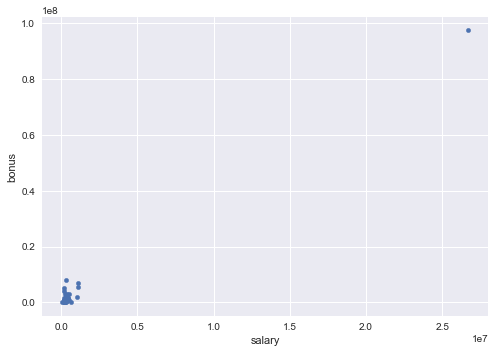

In [12]:
data_df.plot.scatter(x = 'salary', y = 'bonus')

No gráfico vemos um ponto muito fora do conjunto, irei usar a linha abaixo para verificar quem é o sujeito.

In [13]:
data_df['salary'].idxmax()

'TOTAL'

A saída revela a variável _TOTAL_, esse camarada já é conhecido. Na célula a seguri irei excluí-lo e plotar o gráfico mais uma vez com os mesmos eixos x / y do anterior. Aproveito também para excluir os outros dois registros que não serão utilizados _LOCKHART EUGENE E_ e o _THE TRAVEL AGENCY IN THE PARK_.

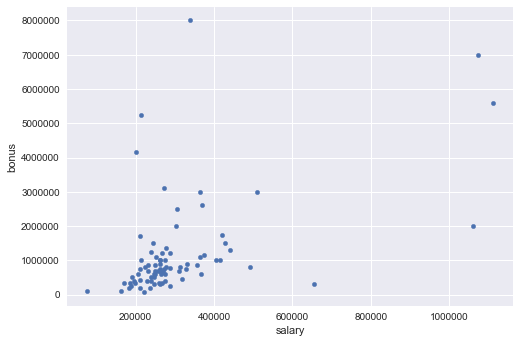

In [14]:
data_df.drop('TOTAL', inplace = True)
data_df.plot.scatter(x = 'salary', y = 'bonus')

In [15]:
# Eliminar os 2 registros irrelevantes
data_dict.pop('LOCKHART EUGENE E', None)
data_df = data_df.drop(['LOCKHART EUGENE E'])
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', None)
data_df = data_df.drop(['THE TRAVEL AGENCY IN THE PARK'])

# Criando novas características

No conjunto de nossos dados temos a quantidade de e-mails enviados às Pessoas de Interesse (POI) e recebidos dessas Pessoas de Interesse para a maioria dos funcionários. E quanto mais e-mail os funcionários trocam entre si, maior a probabilidade de haverem trocas entre e-mails com os POI em questão. Por esse motivo será criado as duas características:

* fração de 'to_messages' recebida de um POI; 

* fração de 'from_messages' enviada para um POI.

Estes podem indicar se a maioria dos e-mails de um funcionário foi trocado com uma Pessoa de Interesse, e serão agrupados em um gráfico de dispersão das duas novas características.

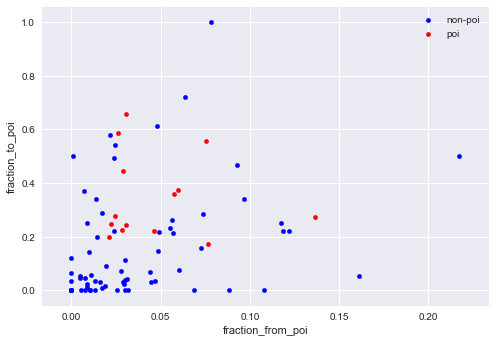

In [16]:
data_df['fraction_from_poi'] = data_df['from_poi_to_this_person'] / data_df['to_messages']
data_df['fraction_to_poi'] = data_df['from_this_person_to_poi'] / data_df['from_messages']

# Gerar scatterplot
ax = data_df[data_df['poi'] == False].plot.scatter(x='fraction_from_poi', y='fraction_to_poi', color='blue', label='non-poi')
data_df[data_df['poi'] == True].plot.scatter(x='fraction_from_poi', y='fraction_to_poi', color='red', label='poi', ax=ax)

# Escalando as novas características

In [18]:
from IPython.display import Image
Image(url="https://media1.tenor.com/images/deb1309a389c9ec38801d3b33ab3fe80/tenor.gif?itemid=8279103")

Diversos modelos de aprendizagem de máquina precisam que os recursos estejam dimensionados e para isso testei uma padronização destes recursos para a pipeline de classificação, afim de melhorar a pontuação de avaliação dos modelos. Para tal, fiz uso do módulo _StandardScaler_ do scikit learn, removendo a média e escalando para a variância unitária.

O _StandardScaler_ é usado para dimensionar os recursos de acordo com a variação de unidade, ou seja, normalizar os dados faz com que os recursos com valores amplamente distribuídos não tenham peso excessivo na função objetiva.

# Selecionando as principais características

O passo a seguir será selecionar, pelo pipeline, as características que mais transmitam informações e deixar outras para trás visando dois benefícios, reduzir o ruído na classificação e reduzir o tempo de processamento, uma vez que há menos carcterísticas a se calcular.

Por definição uma pipeline é todo processo de converter linhas de dados para dados que sejam úeis para usar nos algoritmos, treinar os modelos e finalmente utilizar as saídas para tomar ações no mundo real. Esse processo sequencial leva esse nome porque se faz uma analogia aos tubos físicos que transportam líquidos e tudo mais.

Para este trabalho foi utilizado os modelos Naive Bayes, kMeans, AdaBoost e Random Forest. O algorítmo que me apresentou melhores resultados foi o Gaussian Naive-Bayes, pois através deste eu obtive as melhores pontuações na maioria das métricas e obtive as características de maior relevância, que são estas:

* total_stock_value
* exercised_stock_options
* salary
* bonus
* fraction_to_poi
* restricted_stock
* expenses
* shared_receipt_with_poi
* deferred_income
* from_poi_to_this_person

Vale ressaltar que em geral quanto maior for o score f1 melhor é o modelo, pois esta métrica indica a qualidade geral do modelo. Abaixo segue um comparativo entre os resultados. Os classificadores completos se encontram no final deste artigo.

| Classificadores | Accuracy | Precision | Recall | f1 |
| :-----: | :-----: | :-----: |  :-----: |  :-----: |
| Naive Bayes | 0.84 | 0.40 | 0.33 | 0.36 |
| KMeans | 0.85 | 0.26 | 0.09 | 0.13 |
| AdaBoost | 0.83 | 0.35 | 0.27 | 0.30 |
| Random Forest | 0.86 | 0.42 | 0.16 | 0.23 |

# Afinando o algoritmo

Uma parte crucial da seleção de um algoritmo de aprendizagem de máquina é ajustar seus parâmetros e se não estiverem adequadamente sintonizados, o algoritmo pode se sub-ajustar (_underfitting_) ou sobre-ajustar (_overfitting_) aos dados, ocorrendo alto índices de erro.

In [19]:
from IPython.display import Image
Image(url="https://www.safaribooksonline.com/library/view/deep-learning/9781491924570/assets/dpln_0107.png")

Para afinar os algoritmos usei a ferramenta _GridSearchCV_ e o ".best_estimator" para o melhor estimador, que busca exaustivamente os melhores parâmetros e combinações entre os especificados. Os parâmetros foram escolhidos para otimizar a métrica f1 (métrica tida como base para o projeto de conclusão).

# Estratégia de validação

A validação é o processo de aplicação do modelo para uma parte do conjunto de dados, que não foi usada durante o ajuste para avaliar sua capacidade de generalização. Na falta do número necessário de pontos de dados para dividir o conjunto, diversas divisões randomizadas podem ser usadas para a criação e validação do modelo. Um erro clássico é usar os mesmos dados (sem Validação Cruzada) tanto para a criação como para a avaliação, isso leva os modelos a ficarem altamente tendenciosos com desempenho muito fraco em novos pontos de dados.

Uma vez que existem poucas observações para treinar e testar os algoritmos para extrair a maior parte da informação dos dados, a estratégia aplicada para validar o modelo foi a Validação Cruzada _Stratified Shuffle Split_, que é o iterador recomendado para conjuntos de dados com um grande desequilíbrio na distribuição das classes alvo, como é o caso dos e-mails e os dados financeiros em que há um número muito maior de não POI do que de POI. Segundo a definição da documentação do scikit learn, este objeto de validação cruzada é uma fusão do _StratifiedKFold_ e _ShuffleSplit_, que retorna dobras aleatorizadas estratificadas. As dobras são feitas preservando a porcentagem de amostras para cada classe.

Basicamente é usada uma série de _train/validation/test_. No loop interno, o _score_ é maximizado no ajuste do modelo para cada conjunto de treino de forma aproximada e também para a seleção de hiperparâmetros no conjunto de validação. No loop externo, o erro de generalização é estimado pela média dos _scores_ do conjunto de testes em várias divisões do _dataset_. Todos os conjuntos são escolhidos aleatoriamente, mas mantendo a mesma proporção de labels de classe.

# Modelos

Através da validação cruzada _Stratified Shuffle Split_ eu dividi o conjunto em 10 grupos (_splits_), por 10x vezes, dos quais 9 foram usados para treino e 1 foi usado para teste. A validação cruzada é computacionalmente mais dispendiosa, porém, faz uma utilização exaustiva dos dados tanto na criação da árvore como na estimação do seu erro.

In [20]:
## Característica selecionadas
features_list = ['poi', 'salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments',
                 'loan_advances', 'other', 'expenses', 'director_fees', 'total_payments', 
                 'exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 
                 'total_stock_value', 'to_messages', 'from_messages', 'from_this_person_to_poi', 
                 'from_poi_to_this_person', 'shared_receipt_with_poi', 'fraction_from_poi', 'fraction_to_poi']

### Carregar o dicionário contendo o dataset
filled_df = data_df.fillna(value='NaN') # featureFormat esperado 'NaN' strings

# De volta ao dicionário
data_dict = filled_df.to_dict(orient='index')

### Armazenar ao my_dataset para fácil exportar abaixo
my_dataset = data_dict

### Extrair características e labels do dataset para teste
data = featureFormat(my_dataset, features_list, sort_keys = True)
y, X = targetFeatureSplit(data)
X = np.array(X)
y = np.array(y)

### Cross-validation - pré-configurado para divisão de 10 splits com 1 parte para teste, Sem pré-config. para treino.
### random_state = 42 garante sempre o mesmo output todas a vezes que rodar o modelo.
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=42)

# hiperparâmetros completos - os modelos irão escolher entre os parâmetros abaixo aqueles que melhor se enquadram
SCALER = [None, StandardScaler()]
SELECTOR__K = [10, 13, 15, 18, 'all']

* O _Stratified Shuffle Split_ é como um parâmetro para o _grid search_ e faz uma busca em grade por todas as combinações possíveis de parâmetros definidos, para cada busca irá avaliar usando validação cruzada e o _score_ final será determinado pela própria validação.
* O _test size_ define a porcentagem de eventos atribuídos ao conjunto de teste.
* O _random state_ controla quais pontos são incluídos no conjunto de treinamento. Definir um valor fixo garante que a mesma sequência de números aleatórios seja gerada sempre que você executar o código, ao menos que haja alguma aleatoriedade presente no processo, os resultados produzidos serão sempre os mesmos.

In [21]:
def evaluate_model(grid, X, y, cv):
    nested_score = cross_val_score(grid, X=X, y=y, cv=cv, n_jobs=-1)
    print "Nested f1 score: {}".format(nested_score.mean())

    grid.fit(X, y)    
    print "Best parameters: {}".format(grid.best_params_)

    cv_accuracy = []
    cv_precision = []
    cv_recall = []
    cv_f1 = []
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        grid.best_estimator_.fit(X_train, y_train)
        pred = grid.best_estimator_.predict(X_test)
        
        cv_accuracy.append(accuracy_score(y_test, pred))
        cv_precision.append(precision_score(y_test, pred))
        cv_recall.append(recall_score(y_test, pred))
        cv_f1.append(f1_score(y_test, pred))
        
    print "Mean Accuracy: {}".format(np.mean(cv_accuracy))
    print "Mean Precision: {}".format(np.mean(cv_precision))
    print "Mean Recall: {}".format(np.mean(cv_recall))
    print "Mean f1: {}".format(np.mean(cv_f1))

# Melhor Classificador - Naive Bayes

Abaixo foi definido os parâmetros do _param grid_ e do _pipeline_, cujo qual possibilita combinar múltiplos métodos sucessivos tais como; validação cruzada (_StratifiedShuffleSplit_), seleção das características mais importantes (_SelectKBest_), normalização dos dados (_StandardScaler_) e otimização (_GridSearchCV_).

In [22]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest()),
        ('classifier', GaussianNB())
    ])

param_grid = {
    'scaler': SCALER,
    'selector__k': SELECTOR__K,
}

Como mencionado anteriormente, para afinar os algoritmos usei o _GridSearchCV_, resumidamente se busca os melhores parâmetros (_selector k_ e _scaler_) e combinações por "força bruta", obtendo as melhores pontuações.

In [23]:
# sss = StratifiedShuffleSplit
gnb_grid = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)

# Avaliar modelo Naive Bayes
evaluate_model(gnb_grid, X, y, sss)

Nested f1 score: 0.286616161616


C:\Users\Lourdes\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters: {'selector__k': 13, 'scaler': None}
Mean Accuracy: 0.833333333333
Mean Precision: 0.422222222222
Mean Recall: 0.45
Mean f1: 0.386363636364


C:\Users\Lourdes\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
# Testando o modelo - tester.py
test_classifier(gnb_grid.best_estimator_, my_dataset, features_list)

Pipeline(steps=[('scaler', None), ('selector', SelectKBest(k=13, score_func=<function f_classif at 0x082949B0>)), ('classifier', GaussianNB(priors=None))])
	Accuracy: 0.84420	Precision: 0.39744	Recall: 0.32650	F1: 0.35850	F2: 0.33859
	Total predictions: 15000	True positives:  653	False positives:  990	False negatives: 1347	True negatives: 12010



O projeto inicial exigia a utilização do algoritmo "testador" (_tester.py_) fornecido pela Udacity, era necessário ter como parâmetro as pontuações obtidas por ele e assim, definir os melhores modelos. Como requisito o _precision_ e o _recall_ precisava atingir o mínimo de 0.3 para atender a rubrica e o Naive Bayes foi o único que atendeu.

_Precision_ mais alto significa que o algoritmo retornou substancialmente mais resultados relevantes que irrelevantes, enquanto que _recall_ mais alto significa que o algoritmo retornou a maioria dos resultados relevantes (Wikipedia).

In [25]:
from IPython.display import Image
Image(url="https://upload.wikimedia.org/wikipedia/commons/thumb/a/ab/Precis%C3%A3o_e_revoca%C3%A7%C3%A3o.png/320px-Precis%C3%A3o_e_revoca%C3%A7%C3%A3o.png")

**Select K Best**

O método _SelectKBest_ do scikit-learn usa a função _f classif_ de pontuação, no qual calcula o valor ANOVA F entre _labels_ e _features_ para tarefas de classificação. 

O método funciona basicamente fazendo uma análise de correlação entre as variáveis, selecionando as mais relevantes para o modelo. Temos então uma lista com as 13 melhores variáveis, que são as mesmas mostradas no tópico "Selecionando as principais características".

In [26]:
from sklearn.feature_selection import SelectKBest

# Melhores características
labels, features = targetFeatureSplit(data)

k_best = SelectKBest(k=13)
k_best.fit(features, labels)
scores = k_best.scores_
unsorted_pairs = zip(features_list[1:], scores)
sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))

In [27]:
sorted_pairs_kb_df = pd.DataFrame.from_dict(sorted_pairs)
sorted_list = sorted_pairs_kb_df[0].tolist()

In [28]:
k_best = SelectKBest(k=13)
k_best.fit(features, labels)
scores = k_best.scores_
unsorted_pairs = zip(features_list[1:], scores)
sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))

sorted_pairs_kb_df = pd.DataFrame.from_dict(sorted_pairs)
best_features_list = sorted_pairs_kb_df[0].tolist()
best_features_list = best_features_list[:13]
print best_features_list

['exercised_stock_options', 'total_stock_value', 'bonus', 'salary', 'fraction_to_poi', 'deferred_income', 'long_term_incentive', 'restricted_stock', 'total_payments', 'shared_receipt_with_poi', 'loan_advances', 'expenses', 'from_poi_to_this_person']


A seguir, plotei em gráfico de barras essas mesmas características, na sua ordem de relevância.

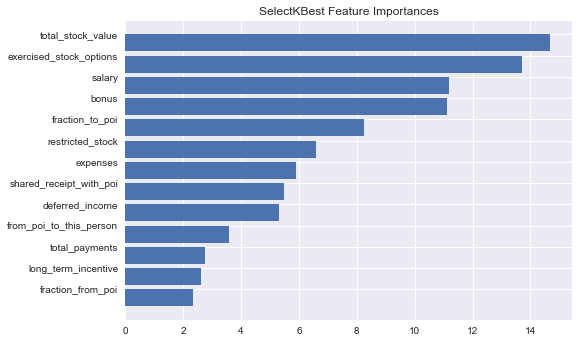

In [29]:
kbest = gnb_grid.best_estimator_.named_steps['selector']

features_array = np.array(features_list)
features_array = np.delete(features_array, 0)
indices = np.argsort(kbest.scores_)[::-1]
k_features = kbest.get_support().sum()

features = []
for i in range(k_features):
    features.append(features_array[indices[i]])

features = features[::-1]
scores = kbest.scores_[indices[range(k_features)]][::-1]

plt.barh(range(k_features), scores)
plt.yticks(np.arange(0.4, k_features), features)
plt.title('SelectKBest Feature Importances')
plt.show()

# Classificador - KMeans

Pela análise do _tester.py_ este modelo apresentou precision de 0.26 e recall de 0.08 e não atendeu a rubrica do projeto.

In [30]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest()),
        
        ('classifier', KMeans(n_clusters=2, random_state=42))
    ])

param_grid = {
    'scaler': SCALER,
    'selector__k': SELECTOR__K,

}

kmeans_grid = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)

# Avaliar o modelo KMeans
evaluate_model(kmeans_grid, X, y, sss)

# Testando o modelo - tester.py
test_classifier(kmeans_grid.best_estimator_, my_dataset, features_list)

Nested f1 score: 0.0696428571429
Best parameters: {'selector__k': 10, 'scaler': None}
Mean Accuracy: 0.9
Mean Precision: 0.4
Mean Recall: 0.25
Mean f1: 0.3
Pipeline(steps=[('scaler', None), ('selector', SelectKBest(k=10, score_func=<function f_classif at 0x082949B0>)), ('classifier', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0))])
	Accuracy: 0.84620	Precision: 0.26421	Recall: 0.08600	F1: 0.12976	F2: 0.09941
	Total predictions: 15000	True positives:  172	False positives:  479	False negatives: 1828	True negatives: 12521



# Classificador - AdaBoost

Este modelo apresentou precision de 0.34, porém recall de 0.26 e não atendeu a rubrica por pouco, foi o segundo melhor modelo testado.

In [31]:
from IPython.display import Image
Image(url="https://media.giphy.com/media/xTiTnuISWBtO3djSCs/giphy.gif")

In [32]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest()),
        # ('reducer', PCA(random_state=42)), - parâmetro relacionado ao PCA que não irei utilizar
        ('classifier', AdaBoostClassifier(random_state=42))
    ])

param_grid = {
    'scaler': SCALER,
    'selector__k': SELECTOR__K,
    # 'reducer__n_components': REDUCER__N_COMPONENTS - parâmetro relacionado ao PCA que não irei utilizar
}

adab_grid = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)

# Avaliar o modelo AdaBoost
evaluate_model(adab_grid, X, y, sss)

# Testando o modelo - tester.py
test_classifier(adab_grid.best_estimator_, my_dataset, features_list)

Nested f1 score: 0.313333333333
Best parameters: {'selector__k': 10, 'scaler': None}
Mean Accuracy: 0.86
Mean Precision: 0.433333333333
Mean Recall: 0.4
Mean f1: 0.393333333333
Pipeline(steps=[('scaler', None), ('selector', SelectKBest(k=10, score_func=<function f_classif at 0x082949B0>)), ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42))])
	Accuracy: 0.83487	Precision: 0.34662	Recall: 0.26950	F1: 0.30323	F2: 0.28205
	Total predictions: 15000	True positives:  539	False positives: 1016	False negatives: 1461	True negatives: 11984



# Classificador - Random Forest

Por fim, a Árvore Aleatória apresentou na precisão (_precision_) 0.41, porém, na revocação (_recall_) 0.16 e também não atendeu a rubrica desejada.

In [33]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest()),
        ('classifier', RandomForestClassifier(max_depth=5, max_features='sqrt', n_estimators=10, random_state=42))
    ])

param_grid = {
    'scaler': SCALER,
    'selector__k': SELECTOR__K,

}

rfc_grid = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)

# Avaliar o modelo KMeans
evaluate_model(rfc_grid, X, y, sss)

# Testando o modelo - tester.py
test_classifier(rfc_grid.best_estimator_, my_dataset, features_list)

Nested f1 score: 0.383333333333
Best parameters: {'selector__k': 18, 'scaler': None}
Mean Accuracy: 0.886666666667
Mean Precision: 0.566666666667
Mean Recall: 0.35
Mean f1: 0.413333333333
Pipeline(steps=[('scaler', None), ('selector', SelectKBest(k=18, score_func=<function f_classif at 0x082949B0>)), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))])
	Accuracy: 0.85827	Precision: 0.41923	Recall: 0.16350	F1: 0.23525	F2: 0.18622
	Total predictions: 15000	True positives:  327	False positives:  453	False negatives: 1673	True negatives: 12547



Foi um projeto interessante de concluir, no entanto, me deu muito trabalho no início devido há alguns imprevistos. Embora a matemática seja uma ciência exata os problemas reais com os quais nos deparamos manipulando dados, geralmente, nos mostram diversos caminhos e variáveis duvidosas, mas somente o conhecimento das informações, o domínio das ferramentas e o "tempo de estrada" (experiência) é que irão nos apresentar as soluções que melhores se adequam, entretanto não serão as únicas. 

In [34]:
from IPython.display import Image
Image(url="https://palavrassemsentido.files.wordpress.com/2008/03/bifurcacao.jpg?w=477")

# Referências bibliográficas

https://docs.microsoft.com/pt-br/azure/machine-learning/team-data-science-process/spark-model-consumption

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit

http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

http://scikit-learn.org/stable/modules/tree.html

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html